<a href="https://colab.research.google.com/github/UnimaginableDragon/A-Timer-in-Assembly/blob/master/UnsupervisedEvaluationMetric_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
! pip install scipy

Input: A dot file with cluster specified \\
Output: 4- evaluation metric

In [40]:

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [41]:
path = '/content/gdrive/My Drive/Data/data_topic/'

In [42]:
import numpy as np
import networkx as nx
import scipy.sparse as sp

In [43]:
def load_dataset_dot(file_name='simple.dot'):
    fpath = path+file_name
    original_g = nx.Graph(nx.drawing.nx_pydot.read_dot(fpath))
    g = original_g.copy()
    #make the graph unweighted
    N = len(g.nodes)
    edges = list(g.edges)
    g.remove_edges_from(edges)
    g.add_edges_from(edges)
    
    # print(g.nodes)
    # nx.draw_spring(g,with_labels= True)
    A = nx.to_scipy_sparse_matrix(g,format='csr')
    # A=sp.csr_matrix()
    # print(A)
    return A,N, original_g 



In [44]:
def eliminate_symbol(g, s='"'):

    for n in g.nodes:
        if(g.nodes[n]['weight']!=None):
            # print("HERE IT IS")
            g.nodes[n]['weight'] = g.nodes[n]['weight'].replace(s,"")
        if(g.nodes[n]['cluster']!=None):
            g.nodes[n]['cluster'] = g.nodes[n]['cluster'].replace(s,"")
    for e in g.edges():
        if(g.edges[e]['weight']!=None):
            g.edges[e]['weight']=g.edges[e]['weight'].replace(s,"")
    

In [45]:
def nx_to_com_csr(g,basezero=False):
    

    row = []
    col = []
    data = []
    N = 0
    M = 0
    for n in g.nodes:
        # print(g.nodes[n]['cluster'])
        for c in g.nodes[n]['cluster'].split(','):
            # print(c)
            if (basezero):
                row.append(int(n)-1)
                col.append(int(c)-1)
            else:
                row.append(int(n))
                col.append(int(c))
            data.append(1)
            M = max(M, int(c))
            N = max(N, int(n))

    if(basezero==False):
        M += 1   
        N += 1

    Z = sp.csr_matrix((data,(row,col)), shape = (N, M), dtype=np.int8)

    return Z

# print(nx_to_csr(g).toarray())


In [46]:
def dot_to_nx(fpath,f=None):
    g = nx.Graph(nx.drawing.nx_pydot.read_dot(fpath))
    if(f is not None):
        f(g)
    
    return g


In [47]:
def nx_to_dot_with_cluster_label(g, Z, path):  
    # Z is in csr format
    Z = Z.toarray().astype(np.int8)
    for n in g.nodes:
        label='"'
        row = Z[int(n), : ]

        for i in range(len(row)):
            if(row[i]==1): 
                if(len(label)>1):
                    label=label+','

                label = label + str(i)
        
        label=label+'"'

        g.nodes[n]['cluster'] = label

    nx.drawing.nx_pydot.write_dot(g,path)
    




In [48]:
file_name= input("Provide the name of your file: ")

Provide the name of your file: simple_cluster.dot


In [53]:



__all__ = [
    'evaluate_unsupervised',
    'clustering_coef',
    'coverage',
    'density',
    'conductance',
]


def evaluate_unsupervised(Z_pred, adj):
    return {'coverage': coverage(Z_pred, adj),
            'density': density(Z_pred, adj),
            'conductance': conductance(Z_pred, adj),
            'clustering_coef': clustering_coef(Z_pred, adj)}


def clustering_coef(Z_pred, adj):
    """Compute weighted average of clustering coefficients of communities."""
    def clustering_coef_community(ind, adj):
        """Compute clustering coefficient of a single community."""
        adj_com = adj[ind][:, ind]
        n = ind.sum()
        if n < 3:
            return 0
        # Number of possible triangles
        possible = (n - 2) * (n - 1) * n / 6
        # Number of existing triangles
        existing = (adj_com @ adj_com @ adj_com).diagonal().sum() / 6
        return existing / possible

    Z_pred = Z_pred.astype(bool)
    com_sizes = Z_pred.sum(0)
    clust_coefs = np.array([clustering_coef_community(Z_pred[:, c], adj) for c in range(Z_pred.shape[1])])
    return clust_coefs @ com_sizes / com_sizes.sum()


def coverage(Z_pred, adj):
    """What fraction of edges are explained by at least 1 community?

    Args:
        Z_pred: Binary community affiliation matrix
        adj : Unweighted symmetric adjacency matrix of a graph.
    """
    u, v = adj.nonzero()
    # print("u: ",u.shape)
    # print("v: ",v.shape)
    # print("Z_pred[u]: ",Z_pred[u].shape)
    # print("Z_pred[v]: ",Z_pred[v].shape)
    a = Z_pred[u] * Z_pred[v]
    return ((a).sum(1) > 0).sum() / adj.nnz


def density(Z_pred, adj):
    """Average density of communities (weighted by size).

    Higher is better.

        (\sum_i density(C_i) * |C_i|) / (\sum_j |C_j|)

    Args:
        Z_pred: Binary community affiliation matrix
        adj : Unweighted symmetric adjacency matrix of a graph.
    """
    def density_community(ind, adj):
        ind = ind.astype(bool)
        n = ind.sum()
        if n  < 2:
            return 0.0
        else:
            return adj[ind][:, ind].nnz / (n**2 - n)
    Z_pred = Z_pred.astype(bool)
    com_sizes = Z_pred.sum(0) / Z_pred.sum()
    densities = np.array([density_community(Z_pred[:, c], adj) for c in range(Z_pred.shape[1])])
    return densities @ com_sizes


def conductance(Z_pred, adj):
    """Compute weight average of conductances of communities.

    Conductance of each community is weighted by its size.

        (\sum_i conductance(C_i) * |C_i|) / (\sum_j |C_j|)

    Args:
        Z_pred: Binary community affiliation matrix
        adj : Unweighted symmetric adjacency matrix of a graph.
    """
    def conductance_community(ind, adj):
        """Compute conductance of a single community.

        Args:
            ind: Binary indicator vector for the community.
            adj: Adjacency matrix in scipy.sparse format.
        """
        ind = ind.astype(bool)
        inside = adj[ind, :][:, ind].nnz
        outside = adj[~ind, :][:, ind].nnz
        if inside + outside == 0:
            return 1
        return outside / (inside + outside)

    Z_pred = Z_pred.astype(bool)
    com_sizes = Z_pred.sum(0)
    conductances = np.array([conductance_community(Z_pred[:, c], adj) for c in range(Z_pred.shape[1])])
    return conductances @ com_sizes / com_sizes.sum()


{'coverage': 1.0, 'density': 0.5185185185185185, 'conductance': 0.4582010582010583, 'clustering_coef': 0.0}


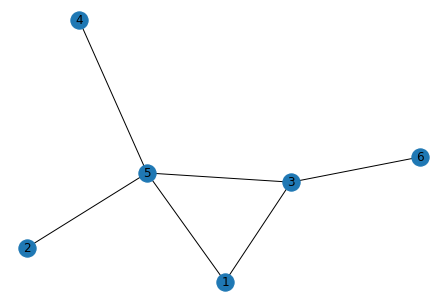

In [54]:

adj, _, g = load_dataset_dot(file_name)
eliminate_symbol(g)

Z = nx_to_com_csr(g,basezero=True)
# adj = nx.to_scipy_sparse_matrix(g)
# print("adj: \n",adj.toarray())
# print("Z:   \n", Z.toarray())
metric= evaluate_unsupervised(Z.toarray(),adj)
print(metric)